<a href="https://colab.research.google.com/github/zseebrz/colab/blob/main/tutorials/rl_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#first clone the github repo and then install from local
!git clone https://github.com/SberProcessMining/Sber_Process_Mining.git

!pip install Sber_Process_Mining/.

Cloning into 'Sber_Process_Mining'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (471/471), done.
remote: Compressing objects: 100% (315/315), done.
remote: Total 471 (delta 256), reused 331 (delta 149), pack-reused 0
Receiving objects: 100% (471/471), 4.12 MiB | 9.94 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Processing ./Sber_Process_Mining
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 26.5 MB 1.5 MB/s 
     |████████████████████████████████| 786 kB 46.3 MB/s 
     |████████████████████████████████| 10.3 MB 39.8 MB/s 
     |████████████████████████████████| 583 kB

In [1]:
from sberpm.ml.reinforcement_learning import RLOptimizer
from sberpm import DataHolder

import pandas as pd

**Reinforcement learning (RL)** is an approach in mashine learning where *actors* learn to choose *actions* in an *environment* in order to maximize *reward* they receive. In **sberpm** RL is used for process reconstruction.

Overview of **reinforcement learning** approach.

- There is an *environment* that has continuous or discrete *states*. There is also an *actor* that has continuous or discrete set of *actions* to choose from. 


- At the beginning *environment* is in some *initial state*. The *actor* takes some *action*. It changes the *state* of the *environment* and the *actor* gets some *reward* for this. This process continues until, for example, the actor reaches some *terminal state* or the number of steps exceed the set limit. The process described above is called a *session*. After the *session* ends the *cumulative reward* is calculsted. The task of the *actor* is to maximize the cumulative session reward. 


- During the training process *actor* participates in many sessions and after each step updates its 'knowledge base' based on the *action* it has done and *reward* it received. At the end the *actor* is expected to perform optimal *action* in each *state* so that it gets maximum cumulative *reward*.

In our case:
- The *environment* has discreet *states* that represent the activities of the process found in the event log.
- The *actor's actions* is a set of activities too. Each *action* (activity) leads to the corresponding *state* (activity) of the *environment*.
- A trained *actor* is supposed to be able to find optimal sequence of activities corresponding to given *reward design*.


Class `RLOptimizer` from __`sberpm.ml.reinforcement_learning`__ module allows to create an environment and an RL-agent, based on the data from `DataHolder`.

There are two types of environment+agent pairs: 
- *exploration* – agent chooses the best action in accordance to the policy,
- *exploitation* – agent chooses the best sequences that are present in the event log.

Methods:
- __define_rewards__ – allows to define rewards
- __fit__ – trains the agent
- __get_optimal_paths__ – returns optimal sequences of states(=event traces) found by the agent in the environment.
- __reset__ – resets agent's and environment's parameters

In [2]:
#downloading the datafile from BPMN challenge 2020
!wget "http://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/DomesticDeclarations.xes_.gz"

--2022-01-09 20:44:25--  http://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/DomesticDeclarations.xes_.gz
Resolving icpmconference.org (icpmconference.org)... 37.128.148.44
Connecting to icpmconference.org (icpmconference.org)|37.128.148.44|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/DomesticDeclarations.xes_.gz [following]
--2022-01-09 20:44:25--  https://icpmconference.org/2020/wp-content/uploads/sites/4/2020/03/DomesticDeclarations.xes_.gz
Connecting to icpmconference.org (icpmconference.org)|37.128.148.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 933930 (912K) [application/x-gzip]
Saving to: ‘DomesticDeclarations.xes_.gz’

DomesticDeclaration 100%[===================>] 912.04K  1.35MB/s    in 0.7s    

2022-01-09 20:44:27 (1.35 MB/s) - ‘DomesticDeclarations.xes_.gz’ saved [933930/933930]



In [3]:
!gunzip DomesticDeclarations.xes_.gz

In [4]:
!pip install pm4py
#install pm4py to convert xes into csv

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 205 kB 67.5 MB/s 
     |████████████████████████████████| 70 kB 6.4 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23598 sha256=fa4800690943de7f6368fcbf26c706ae3f87eb26a730c16c8b858899477ec218
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [5]:
!ls

DomesticDeclarations.xes_  sample_data	Sber_Process_Mining


In [6]:
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply('DomesticDeclarations.xes_')

parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [7]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
dataframe.to_csv('DomesticDeclarations.csv')

In [8]:
#changed file path to reflect previous cells
df = pd.read_csv('DomesticDeclarations.csv')  # Dataset "Domestic Declarations" from BPI Challenge 2020
dh = DataHolder(df, 'case:id', 'concept:name', 'time:timestamp', time_format='%Y-%m-%d')

## 1. Exploration strategy

### Parameters of the environment

- **clear_start_outliers**: If True, starting activities (=initial states in sessions) with low probabilities (less than 5%) will be removed to reduce the movement of the agent in space.

In [9]:
default_env_params = {
    'clear_start_outliers': False
}

### Parameters of the agent

- **discount**: determines the agent's attention on immediate and distant rewards (if it equals 1, immediate and distant rewards are equal; if it is lower than 1, distant rewards are less desirable than the instant ones).
- **alpha**: learning rate for updating the agent
- **epsilon**: probability of performing a random action instead of the best action (epsilon-greedy strategy). By performing a random action the agent literally explores the environment and can to find a better path unknown before. 
- **eps_scaling**: multiplier for decreasing epsilon at each iteration of agent's training. Exploring the environment (=taking random actions) is especially important at the beginning of the training process. At the end when the agents has explored the environment and is quite smart, random actions are needed more rearly for fine tuning.
- **with_prob**: if True, the agent's random action will be performed with the corresponding probabilities from the initial data. Uniform distribution will be used otherwise.

In [10]:
default_agent_params = {
    'discount': 0.9,
    'alpha': 0.09,
    'epsilon': 0.5,
    'eps_scaling': 0.9992,
    'with_prob': False
}

### Reward design

- **default_reward**: agent's reward for performing an action
- **increased_reward**: agent's reward for performing an action leading to a state/activity that is a 'key activity'
- **finish_reward**: agent's reward for performing an action leading to a terminal state/activity
- **duration_reward**: agent reward for completing the trace in less than the average trace time in the original data
- **cycle_penalty**: immediate penalty for coming to a state that has been already visited during the current session. (It is a penalty, so it is subtracted from the total reward.)
- **final_cycle_reward**: agent's reward for completing a trace without loops.
- **presence_reward**: agent's reward for building the trace contained in the initial data

In [11]:
default_reward_design = {
    'default_reward': 15,
    'increased_reward': 0,
    'finish_reward': 100,
    'duration_reward': 0.1,
    'cycle_penalty': 20,
    'final_cycle_reward': 150,
    'presence_reward': 1500
}

### Basic Usage

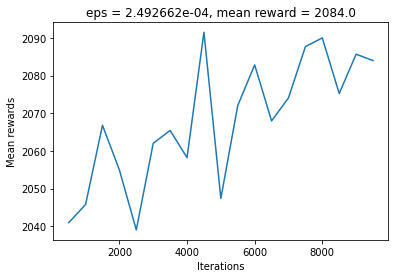

In [12]:
rl = RLOptimizer(dh, strategy='exploration')  # default env_args and agent_args
rl.define_rewards() # default reward_design
result = rl.fit()

In [13]:
result

,trace,duration,reward,num_of_cycles,presence_in_data
0,"(Declaration SAVED by EMPLOYEE, end)",0.000000,1786.427321,0,1
1,"(Declaration SAVED by EMPLOYEE, end)",0.000000,1786.427321,0,1
2,"(Declaration SAVED by EMPLOYEE, end)",0.000000,1786.427321,0,1
3,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",14105.296920,2095.512174,0,1
4,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",14105.296920,2095.512174,0,1
...,...,...,...,...,...
9995,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",11096.887502,2366.353116,0,1
9996,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",11096.887502,2366.353116,0,1
9997,"(Declaration SAVED by EMPLOYEE, end)",0.000000,1786.427321,0,1
9998,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",11096.887502,2366.353116,0,1


In [14]:
rl.get_optimal_paths()

,trace,duration,reward,num_of_cycles,presence_in_data
5,"(Declaration SUBMITTED by EMPLOYEE, Declaratio...",11067.561102,2384.285756,0,1
0,"(Declaration SAVED by EMPLOYEE, end)",0.000000,1786.427321,0,1


In [15]:
_ = [print(el) for el in rl.get_optimal_paths()['trace'].values]

('Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled', 'end')
('Declaration SAVED by EMPLOYEE', 'end')


## 1. Exploitation strategy

### Parameters of the environment

- **shuffle**: If True, the order of the traces will be changed randomly, otherwaise it is the same is in DataHolder

In [16]:
default_env_params = {
    'shuffle': True
}

### Parameters of the agent

- **discount**: determines the agent's attention on immediate and distant rewards (if it equals 1, immediate and distant rewards are equal; if it is lower than 1, distant rewards are less desirable than the instant ones).
- **alpha**: learning rate for updating the agent

In [17]:
default_agent_params = {
    'discount': 0.9,
    'alpha': 0.1
}

### Reward design

same as in 'exploration' strategy, but here there is no *presence_reward* parameter and *duration_reward* is different

- **default_reward**: agent's reward for performing an action
- **increased_reward**: agent's reward for performing an action leading to a state/activity that is a 'key activity'
- **finish_reward**: agent's reward for performing an action leading to a terminal state/activity
- **duration_reward\***: agent's reward for coming to a state that is faster in duration than the average time of this state in the initial data
- **cycle_penalty**: immediate penalty for coming to a state that has been already visited during the current session. (It is a penalty, so it is subtracted from the total reward.)
- **final_cycle_reward**: agent's reward for completing a trace without loops.

In [18]:
default_reward_design = {
    'default_reward': 2,
    'increased_reward': 0,
    'finish_reward': 20,
    'duration_reward': 10,
    'cycle_penalty': 30,
    'final_cycle_reward': 0
}

### Basic Usage

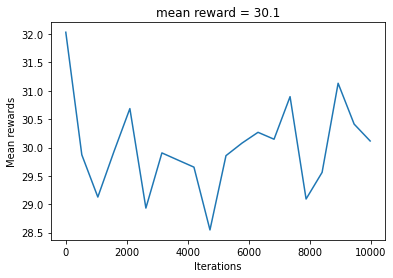

In [19]:
rl = RLOptimizer(dh, strategy='exploitation')  # default env_args and agent_args
rl.define_rewards() # default reward_design
result = rl.fit()

Here the result contains the action-state Q-values

In [20]:
result

,Declaration APPROVED by ADMINISTRATION,Declaration REJECTED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Declaration APPROVED by PRE_APPROVER,Declaration REJECTED by PRE_APPROVER,Declaration REJECTED by SUPERVISOR,Declaration REJECTED by EMPLOYEE,Declaration FOR_APPROVAL by PRE_APPROVER,Declaration FOR_APPROVAL by SUPERVISOR,Declaration FOR_APPROVAL by ADMINISTRATION,Declaration SUBMITTED by EMPLOYEE,Declaration SAVED by EMPLOYEE,Declaration APPROVED by BUDGET OWNER,Declaration REJECTED by BUDGET OWNER,Request Payment,Payment Handled,Declaration REJECTED by MISSING,END_EVENT
Declaration SUBMITTED by EMPLOYEE,22.0,17.0,21.0,18.0,24.0,14.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
START_EVENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0
Declaration APPROVED by ADMINISTRATION,0.0,0.0,21.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,15.0,0.0,0.0,0.0,0.0
Declaration FINAL_APPROVED by SUPERVISOR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,11.0,21.0,0.0
Request Payment,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,5.0,0.0
Payment Handled,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
END_EVENT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Declaration REJECTED by ADMINISTRATION,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
Declaration REJECTED by EMPLOYEE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
Declaration APPROVED by BUDGET OWNER,0.0,0.0,23.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
rl.get_optimal_paths()

['START_EVENT',
 'Declaration SUBMITTED by EMPLOYEE',
 'Declaration REJECTED by PRE_APPROVER',
 'Declaration REJECTED by EMPLOYEE',
 'END_EVENT']

## Additional options

#### 1. Defining env_args, actor_args, reward_design manually + key_states

Let's define 'key states' and a reward for getting to them (*'increased_reward'* argument in reward_design) so that the actor visits them more often.

In [22]:
key_states = [st for st in dh.data[dh.activity_column].unique() if 'APPROVED' in st]
key_states

['Declaration APPROVED by ADMINISTRATION',
 'Declaration FINAL_APPROVED by SUPERVISOR',
 'Declaration APPROVED by BUDGET OWNER',
 'Declaration APPROVED by PRE_APPROVER']

In [23]:
env_args = {
    'clear_start_outliers': False
}

agent_args = {
    'discount': 0.9,
    'alpha': 0.09,
    'epsilon': 0.5,
    'eps_scaling': 0.9992,
    'with_prob': False
}

reward_design = {
    'default_reward': 40,
        'increased_reward': 50,
    'finish_reward': 100,
    'duration_reward': 0.1,
    'cycle_penalty': 20,
    'final_cycle_reward': 50,
    'presence_reward': 300
}

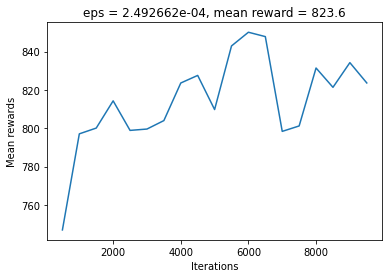

In [24]:
rl = RLOptimizer(dh, strategy='exploration', env_args=env_args, agent_args=agent_args)
rl.define_rewards(reward_design=reward_design, key_states=key_states)
result = rl.fit()

In [25]:
_ = [print(el) for el in rl.get_optimal_paths()['trace'].values]

('Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled', 'end')
('Declaration SAVED by EMPLOYEE', 'end')


#### 2. Define rewards automatically based on the event log (in 'exploitation' mode only)

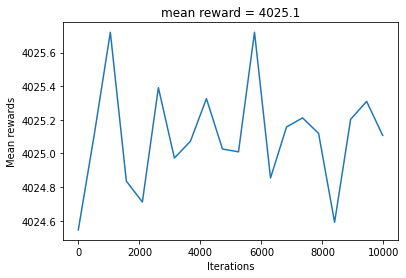

In [26]:
rl = RLOptimizer(dh, strategy='exploitation')
rl.define_rewards(auto=True)
result = rl.fit()

In [30]:
rl.get_optimal_paths()

['START_EVENT', 'Declaration SAVED by EMPLOYEE', 'END_EVENT']